# The file include the base line of our model

### The base line hase the following :
1. using aggregated data( max, avg, sum )
2. No slide window
3. Use StandardScaler

### The matrix:
1. Accuracy
2. F1-score
3. Precision
4. Recall

In [56]:
import numpy as np
from src.xpr_feature_reshaping import aggregate_datasets, aggregate_rows

# Load the datasets
path_app = "src"
dataset0 = np.loadtxt("./%s/data_historical/Code_Red_I.csv" % path_app, delimiter=",")
dataset1 = np.loadtxt("./%s/data_historical/Nimda.csv" % path_app, delimiter=",")
dataset2 = np.loadtxt("./%s/data_historical/Slammer.csv" % path_app, delimiter=",")
dataset3 = np.loadtxt("./%s/data_historical/Moscow_blackout.csv" % path_app, delimiter=",")
dataset4 = np.loadtxt("./%s/data_historical/WannaCrypt.csv" % path_app, delimiter=",")
dataset5 = np.loadtxt("./%s/data_historical/RIPE_regular.csv" % path_app, delimiter=",")
dataset6 = np.loadtxt("./%s/data_historical/BCNET_regular.csv" % path_app, delimiter=",")
datasets = {"Code_Red_I": dataset0, "Nimda": dataset1, "Slammer": dataset2, "Moscow_blackout": dataset3, "WannaCrypt": dataset4, "RIPE_regular": dataset5, "BCNET_regular": dataset6}

In [57]:
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score

def concatenate_datasets(datasets):
    result = datasets[0]
    for dataset in datasets[1:]:
        result = np.concatenate((result, dataset), axis=0)
    return result

def preprocess( dataset, div = 1 ):
    row_index_end = dataset.shape[0] - dataset.shape[0] % div  # divisible by div, but What is div for?
    data_x = dataset[:row_index_end, 4:-1]

    data_y = dataset[:row_index_end, -1]
    # Change training labels
    inds1 = np.where(data_y == -1)
    data_y[inds1] = 2
    return data_x,data_y

from src.VFBLS_v110.bls.processing.one_hot_m import one_hot_m
from src.VFBLS_v110.bls.model.bls_train import bls_train_realtime

print("======================= BLS =======================\n")
def train_test(train_x, train_y, test_x):
    # Set parameters
    mem = 'low'
    # mem = 'high'
    # BLS parameters
    seed = 1  # set the seed for generating random numbers
    num_class = 2  # number of the classes
    epochs = 1  # number of epochs
    C = 2 ** -15  # parameter for sparse regularization
    s = 0.6  # the shrinkage parameter for enhancement nodes
    train_y = one_hot_m(train_y, num_class)
    # test_y = one_hot_m(test_y, num_class);
    #######################
    # N1* - the number of mapped feature nodes
    # N2* - the groups of mapped features
    # N3* - the number of enhancement nodes
    if mem == 'low':
        N1_bls = 20
        N2_bls = 5
        N3_bls = 100
    else:
        N1_bls = 200
        N2_bls = 10
        N3_bls = 100
    #######################

    train_err = np.zeros((1, epochs))
    train_time = np.zeros((1, epochs))
    test_time = np.zeros((1, epochs))
    np.random.seed(seed)  # set the seed for generating random numbers
    for j in range(0, epochs):
        trainingAccuracy, trainingTime, testingTime, predicted = \
        bls_train_realtime(train_x, train_y, test_x,
                            s, C,
                            N1_bls, N2_bls, N3_bls)

        train_err[0, j] = trainingAccuracy * 100
        train_time[0, j] = trainingTime
        test_time[0, j] = testingTime
    # predicted = [[1.], [2.], [2.], [2.], [2.]]
    predicted_list = []
    for label in predicted:
        predicted_list.append(label[0])
    return predicted_list


======================= BLS =======================



In [58]:
import os
import sys
sys.path.append('./src/VFBLS_v110')
from src.xpr_feature_reshaping import *
from sklearn.metrics import precision_score, recall_score, confusion_matrix

def blockPrint():
    old_stdout = sys.stdout
    sys.stdout = open(os.devnull, 'w')
    return old_stdout
def enablePrint(old_stdout):
    sys.stdout = old_stdout

time_span_list = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20, 25, 30, 40, 50, 60]
data_combos = [{"train": ["Code_Red_I", "Nimda"], "test": "Slammer"},
                {"train": ["Nimda", "Slammer"], "test": "Code_Red_I"},
                {"train": ["Code_Red_I", "Slammer"], "test": "Nimda"},]
                # {"train": ["Code_Red_I", "Nimda", "Slammer"], "test": "Moscow_blackout"},]
# all_datasets = ["Code_Red_I", "Nimda", "Slammer", "Moscow_blackout", "WannaCrypt", "RIPE_regular", "BCNET_regular"]

header = ["Train datasets", "Test datasets", "Time span", "Accuracy %", "Fscore %", "Precision %", "Recall %"]
results = []
average_results = []
for time_span in time_span_list:
    averages = np.zeros(len(header)-3)
    for combo in data_combos:
        raw_train_datasets = []
        for name in combo["train"]:
            raw_train_datasets.append(datasets[name])
        raw_test_dataset = datasets[combo["test"]]
        print(f"Data combo: {combo}")
        print("Raw training datasets shape: ", [x.shape for x in raw_train_datasets])
        print("Raw training labels of regular and anomaly: ", [(np.sum(x[:,-1]==-1, axis=0), np.sum(x[:,-1]==1, axis=0)) for x in raw_train_datasets])
        print("Raw test dataset shape: ", raw_test_dataset.shape)
        print("Raw test labels of regular and anomaly: ", np.sum(raw_test_dataset[:,-1]==-1, axis=0), np.sum(raw_test_dataset[:,-1]==1, axis=0))
        train_datasets = aggregate_datasets(raw_train_datasets, time_span)
        test_dataset = aggregate_rows(datasets[combo["test"]], time_span)
        # train_datasets = aggregate_datasets(raw_train_datasets, time_span, True)
        # test_dataset = aggregate_rows(datasets[combo["test"]], time_span, True)
        train_dataset = concatenate_datasets(train_datasets)
        
        train_x, train_y = preprocess(train_dataset)
        test_x, test_y = preprocess(test_dataset)
        train_x, test_x = norm( train_x, test_x, "Std")
        # train_x, test_x = norm( train_x, test_x, "Power")
        old_stdout = blockPrint()

        predicted_list = train_test(train_x, train_y, test_x)
        enablePrint(old_stdout)
        accuracy = accuracy_score(test_y, predicted_list)
        fscore = f1_score(test_y, predicted_list)
        precision = precision_score(test_y, predicted_list)
        recall = recall_score(test_y, predicted_list)

        averages += np.array([accuracy, fscore, precision, recall]) 
        row = ["+".join(combo["train"]), combo["test"], f"{time_span}", f"{accuracy*100:.2f}", f"{fscore*100:.2f}", f"{precision*100:.2f}", f"{recall*100:.2f}"]
        # row = ["+".join(combo["train"]), combo["test"], time_span, accuracy*100, fscore*100]
        results.append(row)
        print(f"Time span: {time_span} - Accuracy: {accuracy:.2%}, Fscore: {fscore:.2%}, Precision: {precision:.2%}, Recall: {recall:.2%}")
    averages = averages / len(data_combos)
    row = ["Average", "Average", f"{time_span}", f"{averages[0]*100:.2f}", f"{averages[1]*100:.2f}", f"{averages[2]*100:.2f}", f"{averages[3]*100:.2f}"]
    average_results.append(row)

# Save the results
file_name = "src/STAT/xpr_results.csv" 

results.insert(0, header)
results.extend(average_results)
results = np.array(results)

os.makedirs(os.path.dirname(file_name), exist_ok=True)
np.savetxt(file_name, results, delimiter=",", fmt="%s")
print("Results saved to", file_name)

Data combo: {'train': ['Code_Red_I', 'Nimda'], 'test': 'Slammer'}
Raw training datasets shape:  [(7200, 42), (8609, 42)]
Raw training labels of regular and anomaly:  [(6600, 600), (7308, 1301)]
Raw test dataset shape:  (7200, 42)
Raw test labels of regular and anomaly:  6331 869
Time span: 1 - Accuracy: 94.47%, Fscore: 72.09%, Precision: 92.28%, Recall: 59.15%
Data combo: {'train': ['Nimda', 'Slammer'], 'test': 'Code_Red_I'}
Raw training datasets shape:  [(8609, 42), (7200, 42)]
Raw training labels of regular and anomaly:  [(7308, 1301), (6331, 869)]
Raw test dataset shape:  (7200, 42)
Raw test labels of regular and anomaly:  6600 600
Time span: 1 - Accuracy: 93.85%, Fscore: 50.28%, Precision: 76.98%, Recall: 37.33%
Data combo: {'train': ['Code_Red_I', 'Slammer'], 'test': 'Nimda'}
Raw training datasets shape:  [(7200, 42), (7200, 42)]
Raw training labels of regular and anomaly:  [(6600, 600), (6331, 869)]
Raw test dataset shape:  (8609, 42)
Raw test labels of regular and anomaly:  7308

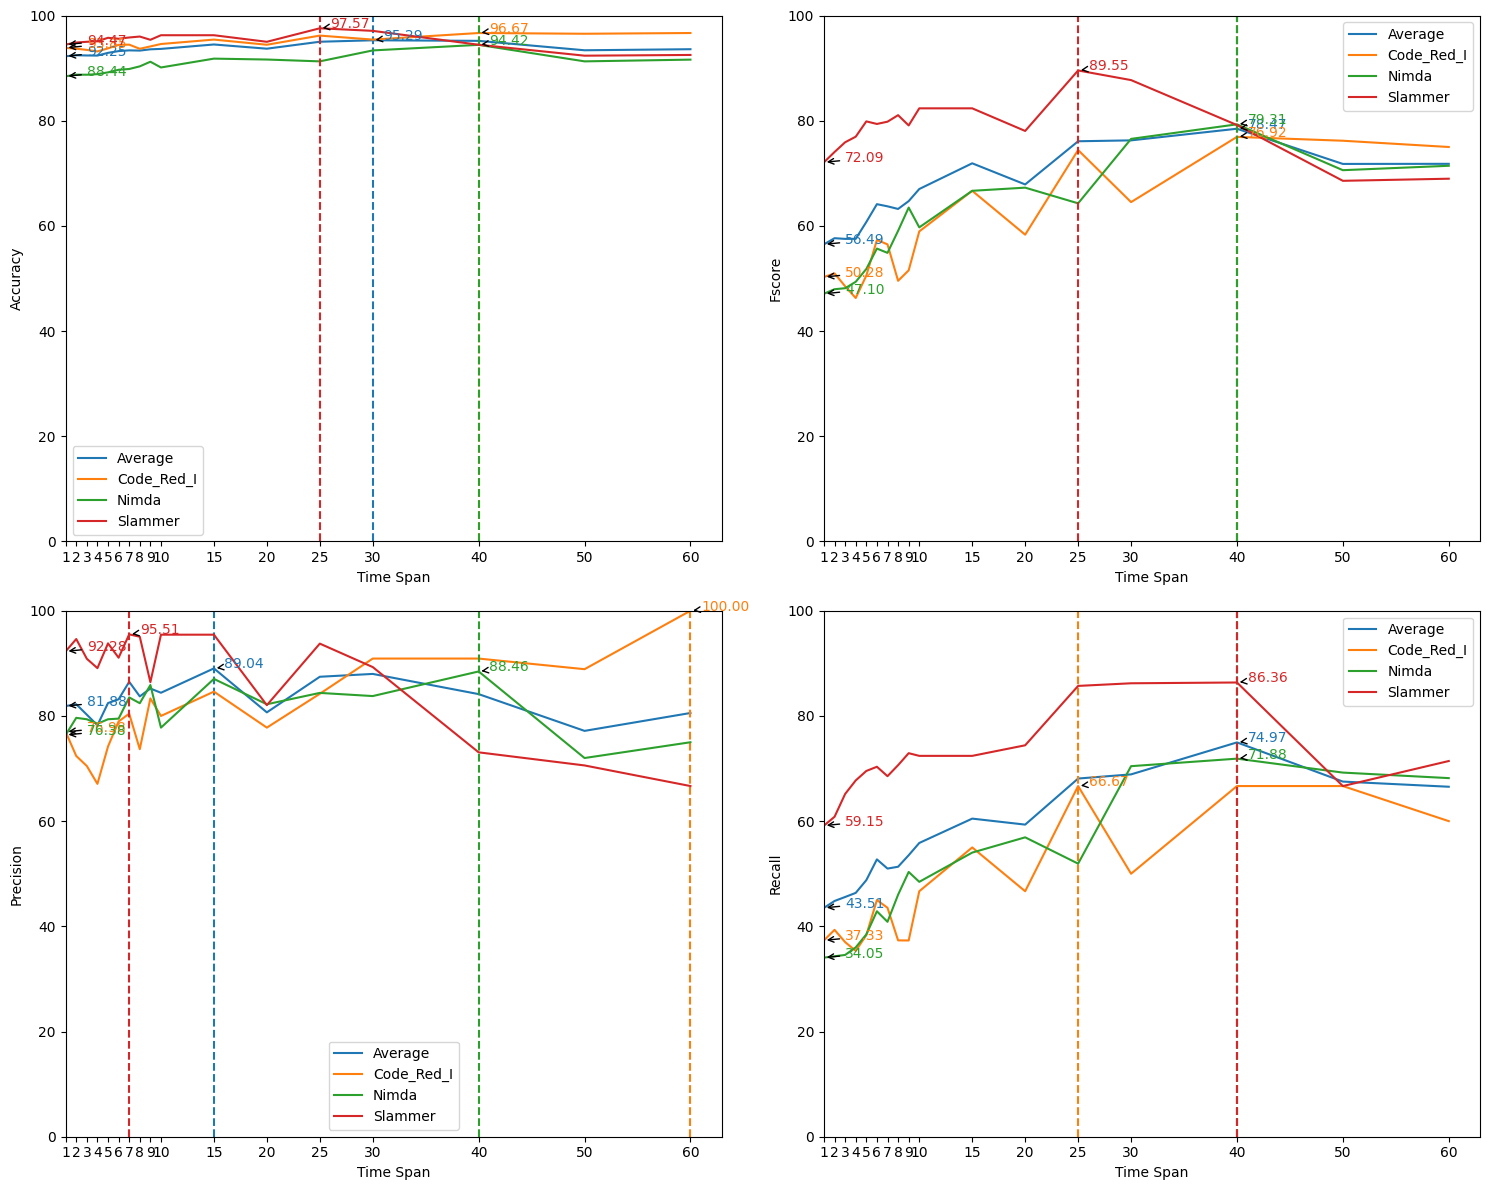

In [59]:
import numpy as np
import matplotlib.pyplot as plt

# Plot each series in a subplot
def subplot(label, series, ax, data_column):
    for series in series:
        mask = np.array([row[1] == series for row in results])
        x = results[mask, 2].astype(int)
        y = results[mask, data_column].astype(float)
        line = ax.plot(x, y, label=series)[0]
        
        # Add annotation for the point of baseline
        ax.annotate(f'{y[0]:.2f}', xy=(x[0], y[0]), xytext=(x[0] + 2, y[0]),
                    color=ax.lines[-1].get_color(), arrowprops=dict(arrowstyle='->'))
        
        # Find the index of the maximum value in y
        max_idx = np.argmax(y)
        max_x = x[max_idx]
        max_y = y[max_idx]
        
        # Draw a vertical line at the maximum value
        ax.axvline(x=max_x, color=ax.lines[-1].get_color(), linestyle='--')
        
        # Annotate the maximum value
        ax.annotate(f'{max_y:.2f}', xy=(max_x, max_y), xytext=(max_x + 1, max_y),
                    color=ax.lines[-1].get_color(), arrowprops=dict(arrowstyle='->'))
    
    ax.set_xlabel('Time Span')
    ax.set_ylabel(label)
    ax.set_xlim(left=1)
    ax.set_ylim(0, 100)
    ax.set_xticks(time_span_list)
    ax.legend()
    # fig.suptitle('Comparison of different time spans')

series = np.unique(results[1:, 1])
fig, ((ax1, ax2),(ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))
subplot('Accuracy', series, ax1, 3)
subplot('Fscore', series, ax2, 4)
subplot('Precision', series, ax3, 5)
subplot('Recall',series, ax4, 6)

plt.tight_layout()
plt.show()